In [136]:
import causalpy as cp

from lifetimes import BetaGeoFitter
from lifetimes.plotting import (plot_period_transactions, 
    plot_calibration_purchases_vs_holdout_purchases, 
    plot_cumulative_transactions, 
    plot_incremental_transactions, 
    plot_transaction_rate_heterogeneity,
    plot_dropout_rate_heterogeneity,
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix)
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.generate_data import beta_geometric_nbd_model_transactional_data

import numpy as np

import pandas as pd

### Generate Synthetic Data

In [173]:
# Set random seed
np.random.seed(300)

# BG/NBD model params for generating synthetic data
params = {
    "a": 0.79, 
    "alpha": 4.41, 
    "b": 2.43, 
    "r": 0.24
}

# Number of totals customers, and customers participating in promotion
N = 5000
N_promo = 300


# Create list of customer dataframes and assign IDs
all_customers = [beta_geometric_nbd_model_transactional_data(T=np.random.randint(1,300), 
                                                             observation_period_end="2023-4-1", 
                                                             freq="D", size=1, **params) 
                 for i in np.arange(N)
                ]

for i in zip(all_customers, np.arange(N)):
    i[0]['customer_id'] = i[1]

# Generate additional transactions for customers participating in marketing campaign
# (This could be iterated with the previous lines to reduce repetition, but not worth the effort to figure out)
promo_customers = [beta_geometric_nbd_model_transactional_data(T=np.random.randint(1,60), observation_period_end="2023-4-1", freq="D", size=1, **params) for i in np.arange(N_promo)]

for i in zip(promo_customers, np.arange(N_promo)):
    i[0]['customer_id'] = i[1]

# Concat above dataframe lists into a single DF
all_customers.extend(promo_customers)

trans_df = pd.concat(all_customers)

In [174]:
# Aggregate transactions by daily count
daily_trans = trans_df.resample("D", on="date").count()
# TODO: Edit date format for charts
#daily_trans['date'] = daily_trans['date'].dt.strftime('%d-%b')

# Add predictors for CausalPy
daily_df = daily_trans.reset_index()
daily_df['days'] = (daily_df['date'] - pd.to_datetime("2022-06-05")).dt.days
daily_df['t'] = daily_df['days'] - 1
# df['t'] = df['t'].astype(float)
daily_df = daily_df.set_index(daily_df['date'])

# Backstory

A company debuted a new consumer product line 300 days ago. Since then, these products have been purchased by 5,000 customers, many of whom have made repeat purchases.

Sales have been steadily increasing since the product line debut, but the company started a marketing campaign 60 days ago to increase sales further. We wish to evaluate the impact of this marketing campaign.

From the daily sales graph below, the impact does not appear immediately apparent:

<Axes: xlabel='date'>

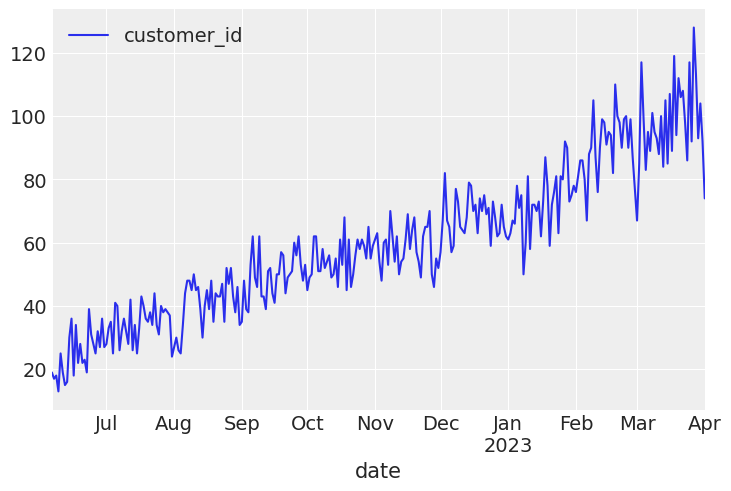

In [175]:
treatment_time = pd.to_datetime("2023-02-01")

daily_trans.plot()

# Causal Inference

We can use CausalPy to create a synthetic control, predicting what sales would have been like had the campaign never happened.

When perfoming causal inference, it is important to consider factors like holidays and seasonality that may adulterate results. This does not appear to be the case in the past year of data, so we may proceed with our analysis.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


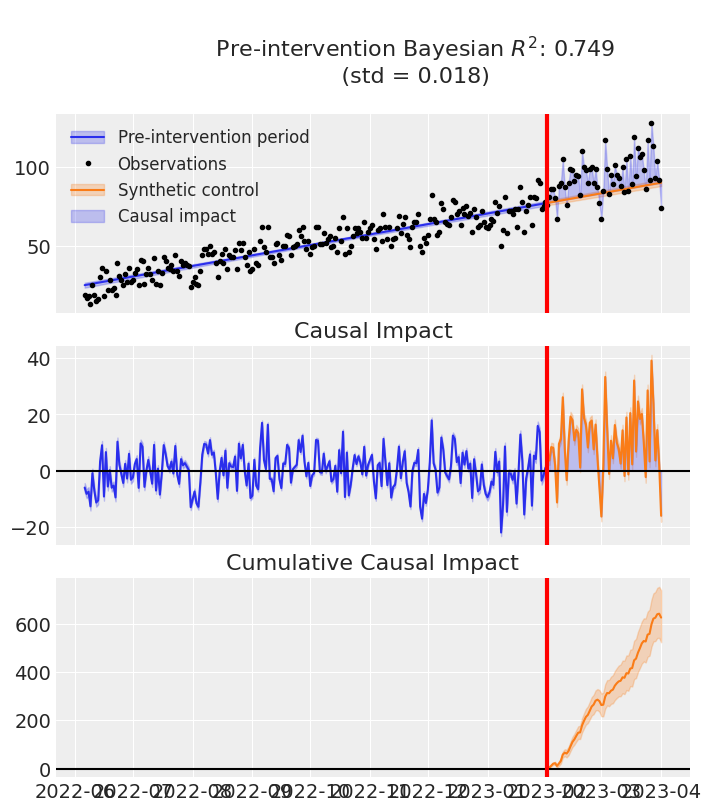

In [176]:
result = cp.pymc_experiments.SyntheticControl(
    daily_df,
    treatment_time,
    formula="customer_id ~ 1 + t",
    model=cp.pymc_models.LinearRegression(),
)

fig, ax = result.plot()

The results suggest a positive impact, but we can go even deeper with our analysis and see how the campaign impacted customer behavior.

# CLV Modeling

The Customer Lifetime Value (CLV) model we will be using is the Beta-Geometric/Negative Binomial Distribution (BG/NBD) model for customer transactions. The BG/NBD model assumes time between transactions for the customer population follows a Gamma distribution, and a dropout probability following a Beta distribution. All customers who have only made a single purchase are presumed still active, and with every new purchase opportunity, there is a chance they may permanently drop out.

Before we fit the BG/NBD model, let's first do a quick analysis on customer transactions before and after the start of the marketing campaign.

In [192]:
# Split transaction data by campaign start date
pre_trans = trans_df[trans_df['date'] <= treatment_time]
post_trans = trans_df[trans_df['date'] > treatment_time]

# RFM format for modeling and easier customer counts
pre_rfm = summary_data_from_transaction_data(pre_trans, 
                                      customer_id_col='customer_id', 
                                      datetime_col='date').reset_index()

post_rfm = summary_data_from_transaction_data(post_trans, 
                                      customer_id_col='customer_id', 
                                      datetime_col='date').reset_index()

# Customer counts pre & post campaign
pre_num = len(pre_rfm)
post_num = len(post_rfm)
overlap = len(pre_rfm.merge(post_rfm, how='inner', on='customer_id'))

# 300 campaign participants
# how many new customers acquired?
existing = len(pre_rfm[pre_rfm['customer_id'] < 300])
acquired = 300 - existing

print(f"Number of customers who made purchases before the campaign: {pre_num}")
print(f"Number of customers who made purchases during the campaign: {post_num}")
print(f"Number of customers who made purchases before & during the campaign: {overlap}")
print(f"Number of new customers during the campaign: {post_num - overlap}")
print(f"Number of existing customers inactive during the campaign: {pre_num - overlap}")

Number of customers who made purchases before the campaign: 3984
Number of customers who made purchases during the campaign: 2064
Number of customers who made purchases before & during the campaign: 1048
Number of new customers during the campaign: 1016
Number of existing customers inactive during the campaign: 2936


Out of the 5,000 customers in the study, nearly 3,000 did not make purchases during the 60-day campaign period. However, this does not mean those customers may not make a purchase in the future. With the BG/NBD model we can estimate the probability of those customers still being active, but this is outside the scope of our campaign evaluation.

Let's look at data on marketing campaign participants: 

In [191]:
print(f"Number of campaign participants: 300")
print(f"Number of existing customers who participated in campaign: {existing}")
print(f"Number of new customers who participated in campaign: {acquired}")
print(f"Potential impact of campaign on new sales: {round((acquired/(post_num - overlap))*100,2)}%")

Number of campaign participants: 300
Number of existing customers who participated in campaign: 246
Number of new customers who participated in campaign: 54
Potential impact of campaign on new sales: 5.31%


Nearly 80% of the customers who participated in the marketing campaign are existing customers, suggesting this campaign was more successful for customer retention than attracting new customers.

Let's go ahead and fit our BG/NBD model. Although only 300 customers have participated in the campaign so far, we targeted the entire customer base with this campaign, so we will be fitting the model to all pre-campaign transactions. 

In [193]:
rfm_df = calibration_and_holdout_data(trans_df, 
                                      customer_id_col='customer_id', 
                                      datetime_col='date', 
                                      calibration_period_end=treatment_time).reset_index()

bgf = BetaGeoFitter().fit(rfm_df['frequency_cal'], rfm_df['recency_cal'], rfm_df['T_cal'])

bgf

<lifetimes.BetaGeoFitter: fitted with 3984 subjects, a: 0.81, alpha: 5.76, b: 2.30, r: 0.26>

To evaluate the performance of our model, there are several graphical methods available. We begin by looking at the frequency of repeat transactions:

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

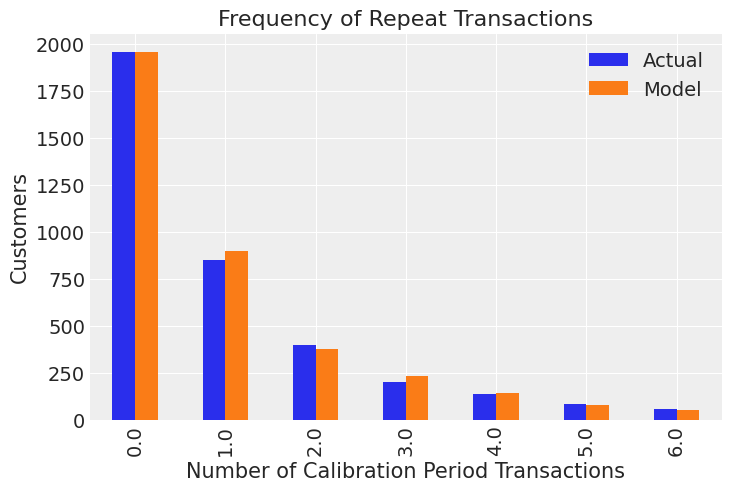

In [194]:
plot_period_transactions(bgf)

This chart displays the amount of customers by the number of transactions they have made before the marketing campaign. We can see the model slightly over-estimates the number of customers who only made 1 or 3 repeat purchase (or two or four transactions in total), but overall the model predictions align well with the purchasing patterns of the customer population.

Similar to the causal inference synthetic control plot, we can also plot daily incremental transactions against the model predictions:

<Axes: title={'center': 'Tracking Daily Transactions'}, xlabel='day', ylabel='Transactions'>

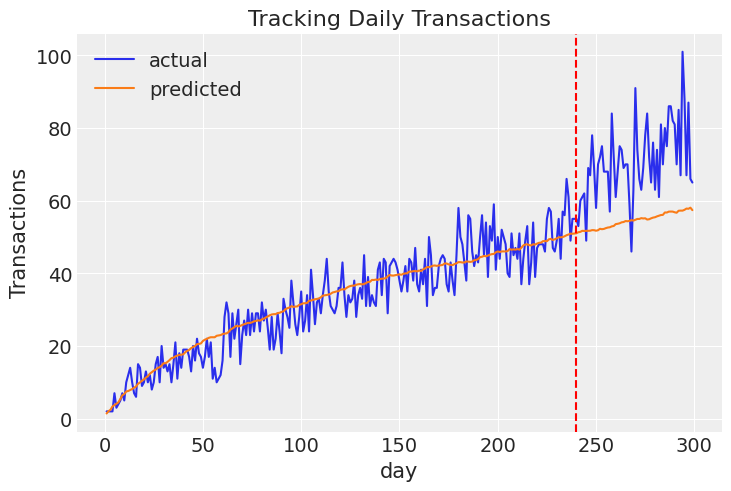

In [184]:
plot_incremental_transactions(bgf,trans_df,customer_id_col='customer_id',datetime_col='date',t=300,t_cal=240)

A noticable increase in daily purchases can be seen during the marketing campaign period. What was the average impact on purchases per customer? 

In [206]:
mean_actual = rfm_df['frequency_holdout'].mean()

mean_pred = bgf.conditional_expected_number_of_purchases_up_to_time(t=60, 
                                                        frequency=rfm_df['frequency_cal'], 
                                                        recency=rfm_df['recency_cal'], 
                                                        T=rfm_df['T_cal']).mean()

print(f"Average purchases per customer during marketing campaign: {round(mean_actual,2)}")
print(f"Predicted purchases per customer during marketing campaign: {round(mean_pred,2)}")

print(f"Current campaign impact on new sales: {round(((mean_actual - mean_pred)/(mean_pred))*100,2)}%")

Average purchases per customer during marketing campaign: 0.8
Predicted purchases per customer during marketing campaign: 0.63
Current campaign impact on new sales: 27.22%


A 27% increase!

Let's compare the total cumulative transactions between customers who participated in the campaign and those that did not.

<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='Cumulative Transactions for Non-Participating Customers', ylabel='Cumulative Transactions'>

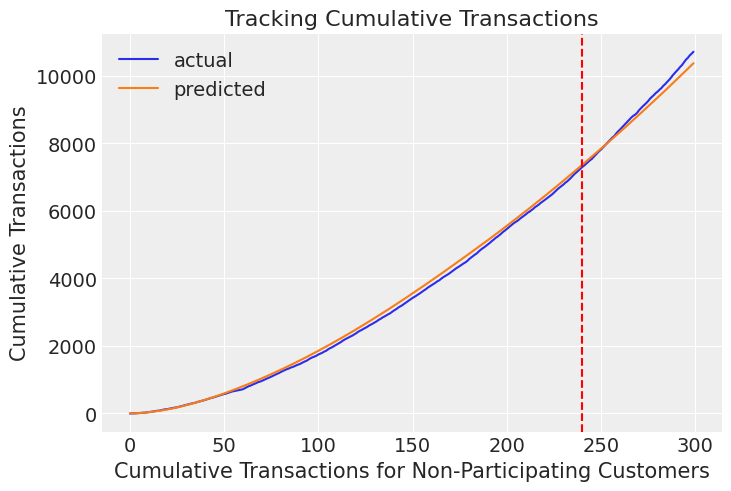

In [210]:
control_trans = trans_df[trans_df['customer_id']>=300]
participants = trans_df[trans_df['customer_id']<300]

plot_cumulative_transactions(bgf,control_trans,datetime_col='date',customer_id_col='customer_id',t=300,t_cal=240, 
                             xlabel="Cumulative Transactions for Non-Participating Customers")

We can see the model closely predicts transaction behavior in our control group - those that did not participate in the campaign.

<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='Cumulative Transactions for Campaign Partipants', ylabel='Cumulative Transactions'>

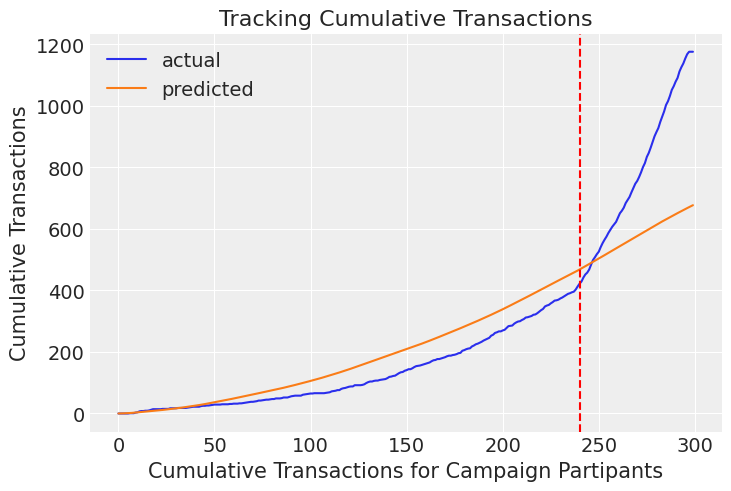

In [212]:
plot_cumulative_transactions(bgf,participants,datetime_col='date',customer_id_col='customer_id',t=300,t_cal=240, 
                             xlabel="Cumulative Transactions for Campaign Partipants")

But there is a marked difference for campaign participants!

We can also compare customers by the number of transactions they made before the marketing campaign, and see how well the model predicted their behavior. This first chart is for customers who did not participant during the campaign:

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

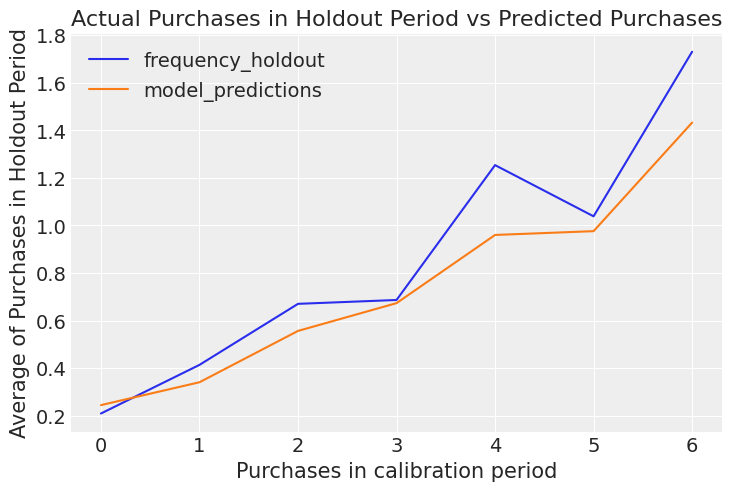

In [215]:
control_rfm = rfm_df[rfm_df['customer_id']>=300]
participants = rfm_df[rfm_df['customer_id']<300]

plot_calibration_purchases_vs_holdout_purchases(bgf,control_rfm, kind='frequency_cal')
#plot_incremental_transactions

The model underpredicts for customers who have made 4 or more repeat purchases, which is understandable for a dataset where the majority of customers have purchased below that amount.

But what about campaign participants?

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

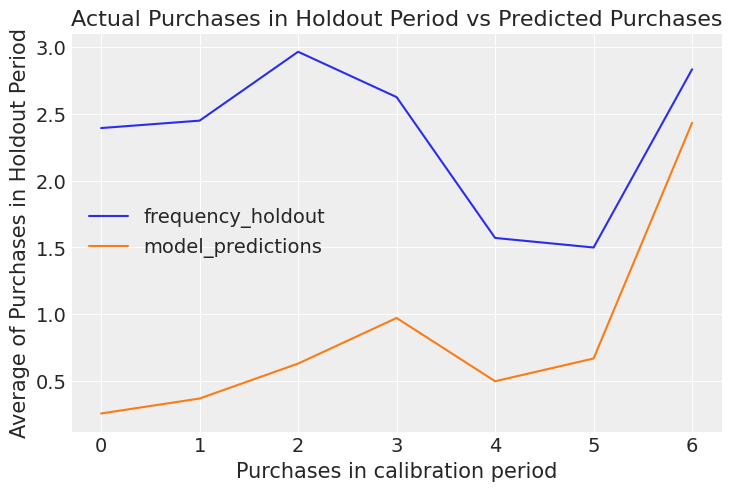

In [216]:
plot_calibration_purchases_vs_holdout_purchases(bgf,participants)

Model predictions are well below actuals for all but the most frequent of customers, with many making multiple purchases.

Next steps for the business may be to profile these customers so that the campaigned may be targeted toward similar consumers, as it is often more cost-effective to retain existing customers than to attract new ones.

In summary, we can see how a well-design causal analysis can give quick answers for the impact of a business decision, and how CLV modeling can illustrate these impacts on indivual purchasing behavior.